In [3]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "C:/Users/shubh/Desktop/dataset.csv"  
data = pd.read_csv(file_path)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Columns: 332 entries, Unnamed: 0 to 7439
dtypes: float64(331), int64(1)
memory usage: 21.9 MB
None


In [7]:
import os

file_path = "C:/Users/shubh/Desktop/dataset.csv"
if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found. Check the file path.")

File exists!


In [11]:

user_data = data['1028']

print(user_data.head())

0    2.631
1    3.178
2    2.599
3    2.630
4    2.480
Name: 1028, dtype: float64


In [15]:

START_DAY = 35
DAYS = 20
ROWS_PER_DAY = 48

start_index = (START_DAY - 1) * ROWS_PER_DAY
end_index = start_index + (DAYS * ROWS_PER_DAY)

user_20_days_data = user_data.iloc[start_index:end_index]

print(user_20_days_data)

1632    3.610
1633    2.558
1634    2.393
1635    2.175
1636    2.166
        ...  
2587    2.911
2588    3.131
2589    2.142
2590    2.133
2591    2.118
Name: 1028, Length: 960, dtype: float64


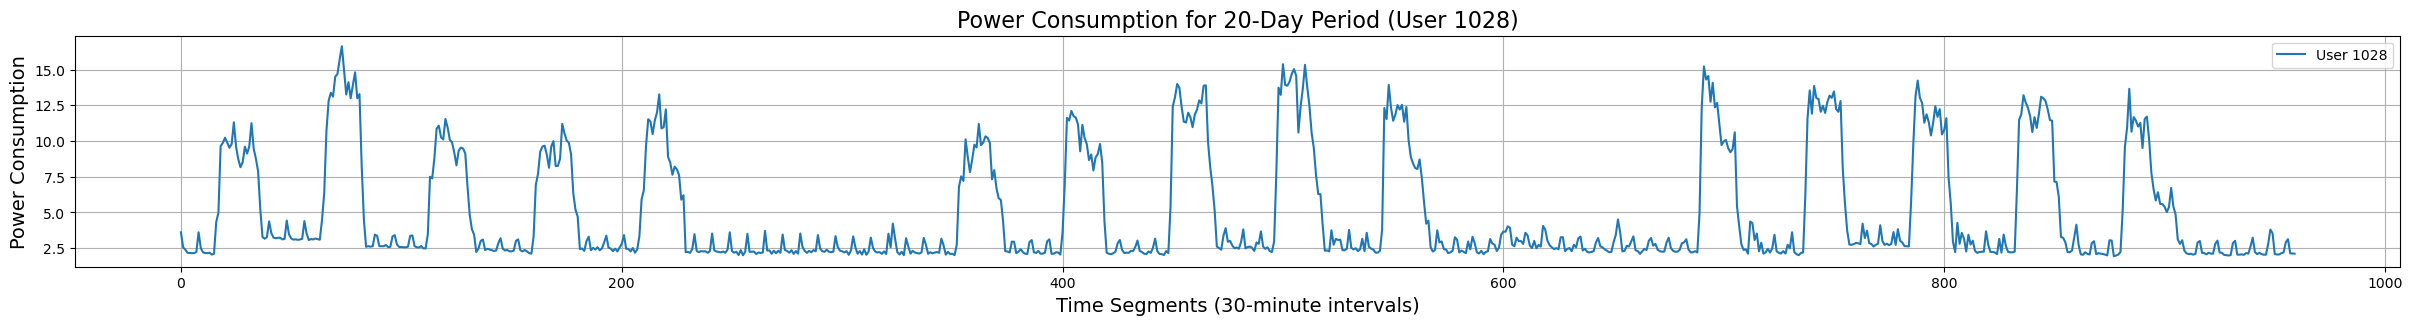

In [19]:
plt.figure(figsize=(30, 3))
plt.plot(user_20_days_data.reset_index(drop=True), label='User 1028')
plt.title('Power Consumption for 20-Day Period (User 1028)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [23]:

alpha = 0.5  # Reduction factor (adjust as needed for severity)

tampered_data = user_data * alpha

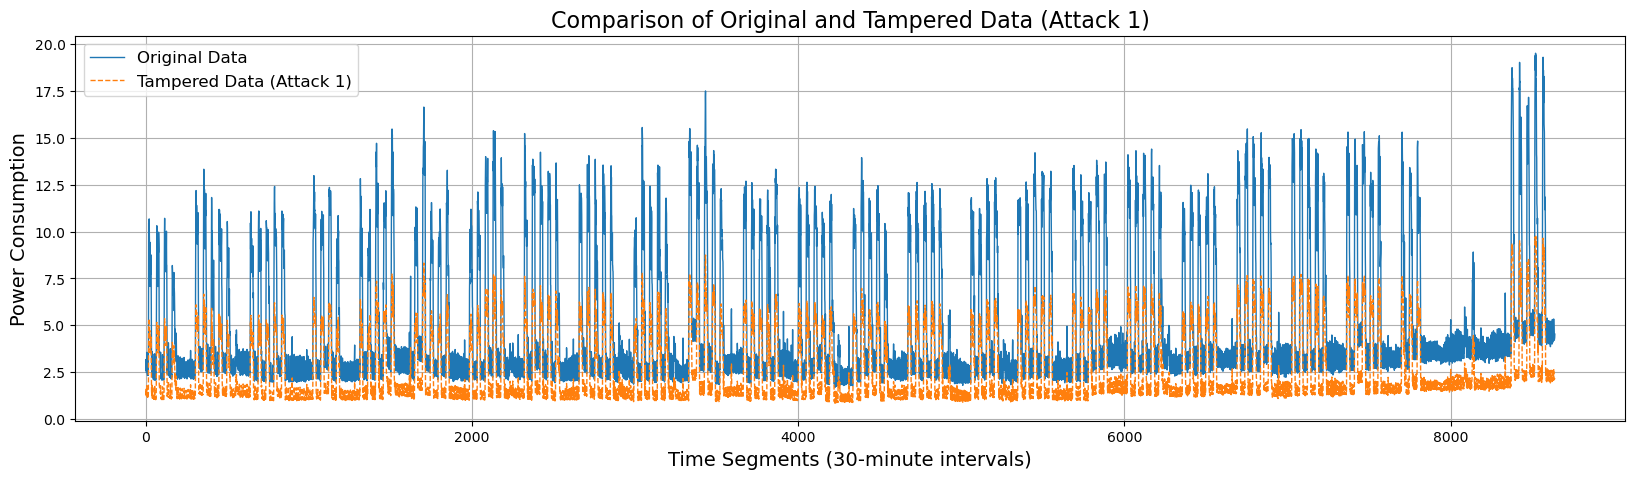

In [27]:
# Plot original data and tampered data for comparison
plt.figure(figsize=(20, 5))
plt.plot(user_data.reset_index(drop=True), label='Original Data', linewidth=1)
plt.plot(tampered_data.reset_index(drop=True), label='Tampered Data (Attack 1)', linestyle='--', linewidth=1)

plt.title('Comparison of Original and Tampered Data (Attack 1)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid()

plt.show()

In [30]:
import pandas as pd
import numpy as np
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

In [34]:
# Generate labels for normal and tampered records
normal_data = user_data.iloc[:960].reset_index(drop=True)  # First 20 days of original data
tampered_data = tampered_data.iloc[:960].reset_index(drop=True)  # Corresponding tampered data for 20 days


combined_data = pd.DataFrame({
    "value": pd.concat([normal_data, tampered_data], ignore_index=True),
    "id": [1] * len(normal_data) + [2] * len(tampered_data),  # Unique IDs for each group
    "time": list(range(len(normal_data))) + list(range(len(tampered_data)))  # Time indices
})

print(combined_data.head())

   value  id  time
0  2.631   1     0
1  3.178   1     1
2  2.599   1     2
3  2.630   1     3
4  2.480   1     4


In [38]:
extraction_settings = ComprehensiveFCParameters()

# Extract features using tsfresh
features = extract_features(
    combined_data,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings
)

print(features.head())

Feature Extraction: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   1.0          4168.5830   
2                       0.0                   1.0          2084.2915   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1       26513.534991                0.588392            0.000096   
2        6628.383748                0.294196            0.000048   

   value__mean_second_derivative_central  value__median  ...  \
1                              -0.000601         2.6890  ...   
2                              -0.000300         1.3445  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.136002                         0.215617   
2      

In [42]:

selected_features = features[[
    "value__minimum",
    "value__maximum",
    "value__mean",
    "value__variance",
    "value__skewness",
    "value__kurtosis"
]]


selected_features.columns = [
    "Minimum", "Maximum", "Mean", "Variance", "Skewness", "Kurtosis"
]

selected_features["Label"] = ["Normal"] + ["Tampered"]


print(selected_features)

   Minimum  Maximum      Mean  Variance  Skewness  Kurtosis     Label
1   1.9630  13.3210  4.342274  8.762922  1.207081 -0.108087    Normal
2   0.9815   6.6605  2.171137  2.190731  1.207081 -0.108087  Tampered


C:\Users\shubh\AppData\Local\Temp\ipykernel_14536\1466860705.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features["Label"] = ["Normal"] + ["Tampered"]


In [46]:

selected_features.to_csv("feature_table_attack_1.csv", index=False)


print(selected_features)

   Minimum  Maximum      Mean  Variance  Skewness  Kurtosis     Label
1   1.9630  13.3210  4.342274  8.762922  1.207081 -0.108087    Normal
2   0.9815   6.6605  2.171137  2.190731  1.207081 -0.108087  Tampered


In [48]:
attack_duration = 48  
zero_start = 10     
zero_end = 20         

tampered_data_attack_2 = user_data.copy()
for day in range(20):  # Apply to 20 days
    start = day * attack_duration + zero_start
    end = day * attack_duration + zero_end
    tampered_data_attack_2.iloc[start:end] = 0 

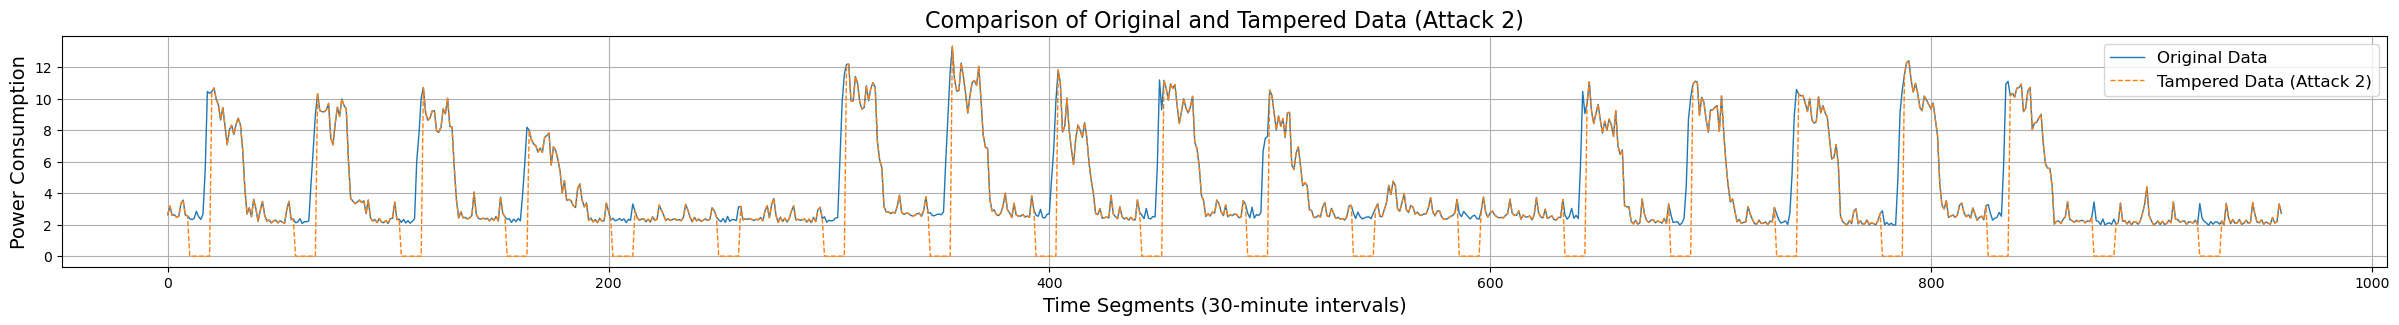

In [54]:

plt.figure(figsize=(30, 3))
plt.plot(user_data.iloc[:960].reset_index(drop=True), label='Original Data', linewidth=1)
plt.plot(tampered_data_attack_2.iloc[:960].reset_index(drop=True), label='Tampered Data (Attack 2)', linestyle='--', linewidth=1)

plt.title('Comparison of Original and Tampered Data (Attack 2)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid()

plt.show()

In [58]:

normal_data = user_data.iloc[:960].reset_index(drop=True)  # First 20 days of original data
tampered_data_attack_2 = tampered_data_attack_2.iloc[:960].reset_index(drop=True)  # Corresponding tampered data


combined_data_attack_2 = pd.DataFrame({
    "value": pd.concat([normal_data, tampered_data_attack_2], ignore_index=True),
    "id": [1] * len(normal_data) + [2] * len(tampered_data_attack_2),  # Unique IDs for each group
    "time": list(range(len(normal_data))) + list(range(len(tampered_data_attack_2)))  # Time indices
})

In [62]:

extraction_settings = ComprehensiveFCParameters()


features_attack_2 = extract_features(
    combined_data_attack_2,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings
)


print(features_attack_2.head())

Feature Extraction: 100%|██████████| 2/2 [00:05<00:00,  2.83s/it]

   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   1.0           4168.583   
2                       1.0                   1.0           3449.961   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1       26513.534991                0.588392            0.000096   
2       22656.519039                0.647030            0.000096   

   value__mean_second_derivative_central  value__median  ...  \
1                              -0.000601         2.6890  ...   
2                              -0.000601         2.5065  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.136002                         0.215617   
2      

In [66]:

selected_features_attack_2 = features_attack_2[[
    "value__minimum",
    "value__maximum",
    "value__mean",
    "value__variance",
    "value__skewness",
    "value__kurtosis"
]]


selected_features_attack_2.columns = [
    "Minimum", "Maximum", "Mean", "Variance", "Skewness", "Kurtosis"
]


selected_features_attack_2["Label"] = ["Normal", "Tampered"]


print(selected_features_attack_2)

   Minimum  Maximum      Mean   Variance  Skewness  Kurtosis     Label
1    1.963   13.321  4.342274   8.762922  1.207081 -0.108087    Normal
2    0.000   13.321  3.593709  10.685794  1.010111 -0.063362  Tampered


C:\Users\shubh\AppData\Local\Temp\ipykernel_14536\2214191332.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_attack_2["Label"] = ["Normal", "Tampered"]


In [70]:

selected_features_attack_2.to_csv("feature_table_attack_2.csv", index=False)


print(selected_features_attack_2)


   Minimum  Maximum      Mean   Variance  Skewness  Kurtosis     Label
1    1.963   13.321  4.342274   8.762922  1.207081 -0.108087    Normal
2    0.000   13.321  3.593709  10.685794  1.010111 -0.063362  Tampered


In [74]:
# Define parameters for Attack 3 
np.random.seed(42)  
gamma_values = np.random.uniform(0.1, 0.8, len(user_data))  # Generate random reduction factors


tampered_data_attack_3 = user_data * gamma_values

In [74]:
 
np.random.seed(42)  # Set a random seed for reproducibility
gamma_values = np.random.uniform(0.1, 0.8, len(user_data))  # Generate random reduction factors


tampered_data_attack_3 = user_data * gamma_values

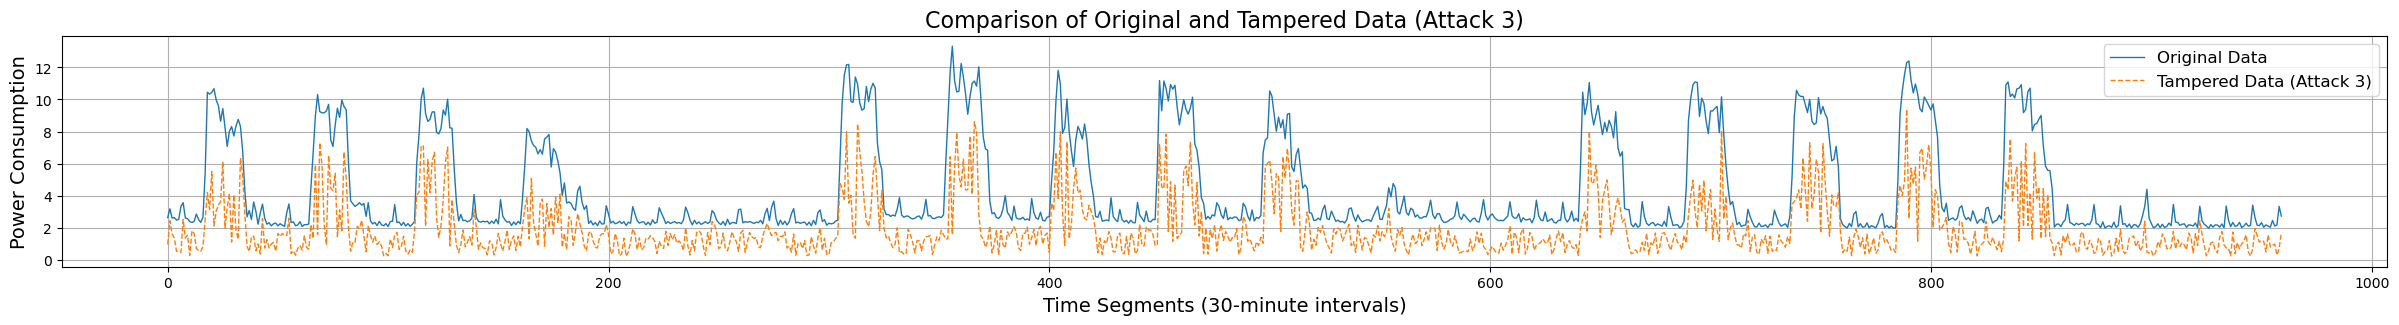

In [80]:

plt.figure(figsize=(30, 3))
plt.plot(user_data.iloc[:960].reset_index(drop=True), label='Original Data', linewidth=1)
plt.plot(tampered_data_attack_3.iloc[:960].reset_index(drop=True), label='Tampered Data (Attack 3)', linestyle='--', linewidth=1)

plt.title('Comparison of Original and Tampered Data (Attack 3)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid()


plt.show()

In [84]:

normal_data = user_data.iloc[:960].reset_index(drop=True)  # First 20 days of original data
tampered_data_attack_3 = tampered_data_attack_3.iloc[:960].reset_index(drop=True)  # Corresponding tampered data


combined_data_attack_3 = pd.DataFrame({
    "value": pd.concat([normal_data, tampered_data_attack_3], ignore_index=True),
    "id": [1] * len(normal_data) + [2] * len(tampered_data_attack_3),  # Unique IDs for each group
    "time": list(range(len(normal_data))) + list(range(len(tampered_data_attack_3)))  # Time indices
})

In [87]:

extraction_settings = ComprehensiveFCParameters()

features_attack_3 = extract_features(
    combined_data_attack_3,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings
)


print(features_attack_3.head())

Feature Extraction: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   1.0        4168.583000   
2                       0.0                   0.0        1855.457779   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1       26513.534991                0.588392            0.000096   
2        6361.583162                1.077708            0.000757   

   value__mean_second_derivative_central  value__median  ...  \
1                              -0.000601       2.689000  ...   
2                              -0.000272       1.403013  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.136002                         0.215617   
2      

In [91]:

selected_features_attack_3 = features_attack_3[[
    "value__minimum",
    "value__maximum",
    "value__mean",
    "value__variance",
    "value__skewness",
    "value__kurtosis"
]]


selected_features_attack_3.columns = [
    "Minimum", "Maximum", "Mean", "Variance", "Skewness", "Kurtosis"
]


selected_features_attack_3["Label"] = ["Normal", "Tampered"]


print(selected_features_attack_3)

    Minimum    Maximum      Mean  Variance  Skewness  Kurtosis     Label
1  1.963000  13.321000  4.342274  8.762922  1.207081 -0.108087    Normal
2  0.220857   9.384583  1.932769  2.891055  1.756863  2.674645  Tampered


C:\Users\shubh\AppData\Local\Temp\ipykernel_14536\1317284513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_attack_3["Label"] = ["Normal", "Tampered"]


In [95]:

selected_features_attack_3.to_csv("feature_table_attack_3.csv", index=False)


print(selected_features_attack_3)

    Minimum    Maximum      Mean  Variance  Skewness  Kurtosis     Label
1  1.963000  13.321000  4.342274  8.762922  1.207081 -0.108087    Normal
2  0.220857   9.384583  1.932769  2.891055  1.756863  2.674645  Tampered


In [99]:

np.random.seed(42)  # Set random seed for reproducibility
periodic_reduction_factor = 0.5  # Reduction factor for specific periods
attack_start_interval = 10  # Start of reduction in a day
attack_end_interval = 20  # End of reduction in a day
intervals_per_day = 48  # 30-minute intervals per day

# Apply Attack 4
tampered_data_attack_4 = user_data.copy()

for day in range(20):  # Apply to 20 days
    start = day * intervals_per_day + attack_start_interval
    end = day * intervals_per_day + attack_end_interval
    tampered_data_attack_4.iloc[start:end] *= periodic_reduction_factor

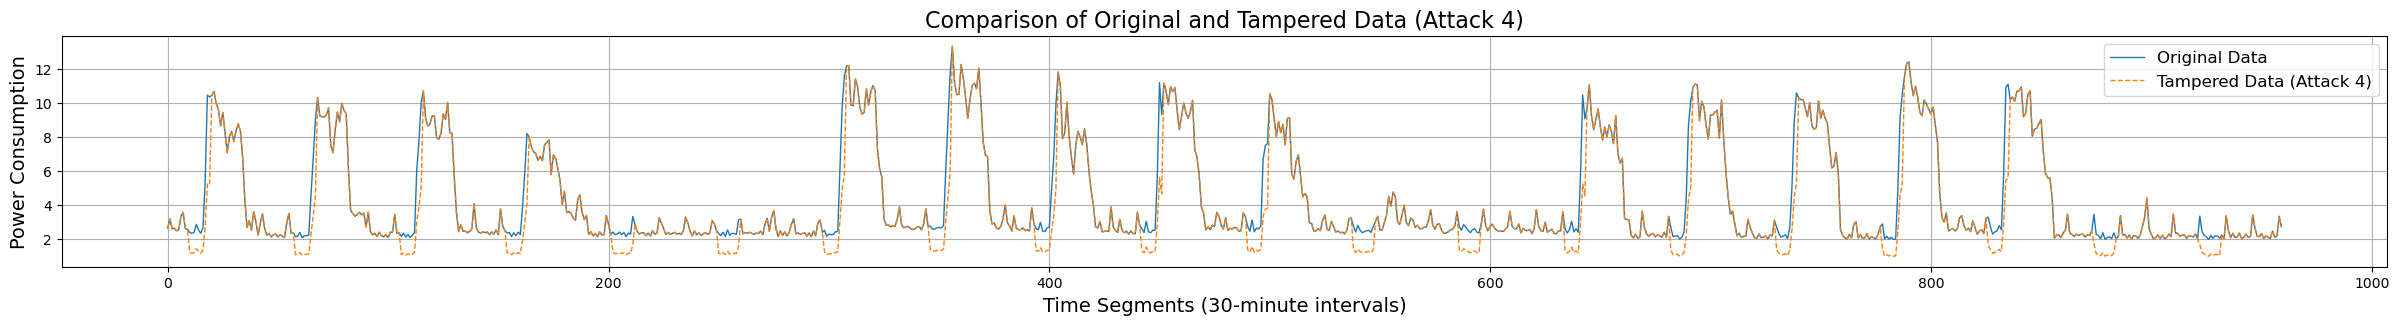

In [105]:
# Plot comparison of original and tampered data
plt.figure(figsize=(30, 3))
plt.plot(user_data.iloc[:960].reset_index(drop=True), label='Original Data', linewidth=1)
plt.plot(tampered_data_attack_4.iloc[:960].reset_index(drop=True), label='Tampered Data (Attack 4)', linestyle='--', linewidth=1)

plt.title('Comparison of Original and Tampered Data (Attack 4)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid()


plt.show()

In [116]:

normal_data = user_data.iloc[:960].reset_index(drop=True)  # First 20 days of original data
tampered_data_attack_4 = tampered_data_attack_4.iloc[:960].reset_index(drop=True)  # Corresponding tampered data


combined_data_attack_4 = pd.DataFrame({
    "value": pd.concat([normal_data, tampered_data_attack_4], ignore_index=True),
    "id": [1] * len(normal_data) + [2] * len(tampered_data_attack_4),  # Unique IDs for each group
    "time": list(range(len(normal_data))) + list(range(len(tampered_data_attack_4)))  # Time indices
})

In [117]:

extraction_settings = ComprehensiveFCParameters()


features_attack_4 = extract_features(
    combined_data_attack_4,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings
)


print(features_attack_4.head())

Feature Extraction: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
1                                             1.0                       0.0   
2                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
1                       0.0                   1.0           4168.583   
2                       0.0                   1.0           3809.272   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
1       26513.534991                0.588392            0.000096   
2       23620.773027                0.612553            0.000096   

   value__mean_second_derivative_central  value__median  ...  \
1                              -0.000601          2.689  ...   
2                              -0.000601          2.599  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
1                        0.136002                         0.215617   
2      

In [122]:

selected_features_attack_4 = features_attack_4[[
    "value__minimum",
    "value__maximum",
    "value__mean",
    "value__variance",
    "value__skewness",
    "value__kurtosis"
]]


selected_features_attack_4.columns = [
    "Minimum", "Maximum", "Mean", "Variance", "Skewness", "Kurtosis"
]


selected_features_attack_4["Label"] = ["Normal", "Tampered"]


print(selected_features_attack_4)

   Minimum  Maximum      Mean  Variance  Skewness  Kurtosis     Label
1   1.9630   13.321  4.342274  8.762922  1.207081 -0.108087    Normal
2   0.9815   13.321  3.967992  8.860014  1.242102  0.180259  Tampered


C:\Users\shubh\AppData\Local\Temp\ipykernel_14536\1353503900.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_attack_4["Label"] = ["Normal", "Tampered"]


In [126]:

selected_features_attack_4.to_csv("feature_table_attack_4.csv", index=False)


print(selected_features_attack_4)

   Minimum  Maximum      Mean  Variance  Skewness  Kurtosis     Label
1   1.9630   13.321  4.342274  8.762922  1.207081 -0.108087    Normal
2   0.9815   13.321  3.967992  8.860014  1.242102  0.180259  Tampered


In [136]:
def attack_12(data, days=20, intervals_per_day=48):
    tampered_data = data.copy()
    attacks = [attack_1, attack_2, attack_3, attack_4]
    
    for day in range(days):
        # Select a random attack
        random_attack = np.random.choice(attacks)
        
        # Apply the selected attack on the daily segment
        start = day * intervals_per_day
        end = start + intervals_per_day
        daily_data = tampered_data.iloc[start:end]
        
        if random_attack == attack_1:
            tampered_data.iloc[start:end] = random_attack(daily_data, alpha=np.random.uniform(0.4, 0.8))
        elif random_attack == attack_2:
            tampered_data.iloc[start:end] = random_attack(daily_data, zero_start=10, zero_end=20)
        elif random_attack == attack_3:
            tampered_data.iloc[start:end] = random_attack(daily_data, gamma_range=(0.2, 0.8))
        elif random_attack == attack_4:
            tampered_data.iloc[start:end] = random_attack(daily_data, reduction_factor=np.random.uniform(0.3, 0.7), attack_start=10, attack_end=20)
    
    return tampered_data


In [152]:
# Attack 1: Constant Reduction
def attack_1(data, alpha=0.5):
    return data * alpha

# Attack 2: On-Off Zero Consumption
def attack_2(data, zero_start=10, zero_end=20):
    tampered_data = data.copy()
    tampered_data.iloc[zero_start:zero_end] = 0
    return tampered_data

# Attack 3: Varying Reduction
def attack_3(data, gamma_range=(0.1, 0.8)):
    gamma_values = np.random.uniform(gamma_range[0], gamma_range[1], len(data))
    return data * gamma_values

# Attack 4: Periodic Reduction
def attack_4(data, reduction_factor=0.5, attack_start=10, attack_end=20):
    tampered_data = data.copy()
    tampered_data.iloc[attack_start:attack_end] *= reduction_factor
    return tampered_data


In [156]:
def attack_12(data, days=20, intervals_per_day=48):
    tampered_data = data.copy()
    attacks = [attack_1, attack_2, attack_3, attack_4]

    for day in range(days):
        # Select a random attack
        random_attack = np.random.choice(attacks)
        
        # Calculate start and end indices for the day
        start = day * intervals_per_day
        end = start + intervals_per_day
        daily_data = tampered_data.iloc[start:end].copy()  # Ensure correct length for the segment
        
        
        if random_attack == attack_1:
            tampered_data.iloc[start:end] = random_attack(daily_data, alpha=np.random.uniform(0.4, 0.8))
        elif random_attack == attack_2:
            tampered_data.iloc[start:end] = random_attack(daily_data, zero_start=10, zero_end=20)
        elif random_attack == attack_3:
            tampered_data.iloc[start:end] = random_attack(daily_data, gamma_range=(0.2, 0.8))
        elif random_attack == attack_4:
            tampered_data.iloc[start:end] = random_attack(daily_data, reduction_factor=np.random.uniform(0.3, 0.7), attack_start=10, attack_end=20)
    
    return tampered_data


In [160]:

tampered_data_attack_12 = attack_12(user_data.iloc[:960].reset_index(drop=True))


In [164]:
print(f"Original length: {len(user_data.iloc[:960])}, Tampered length: {len(tampered_data_attack_12)}")


Original length: 960, Tampered length: 960


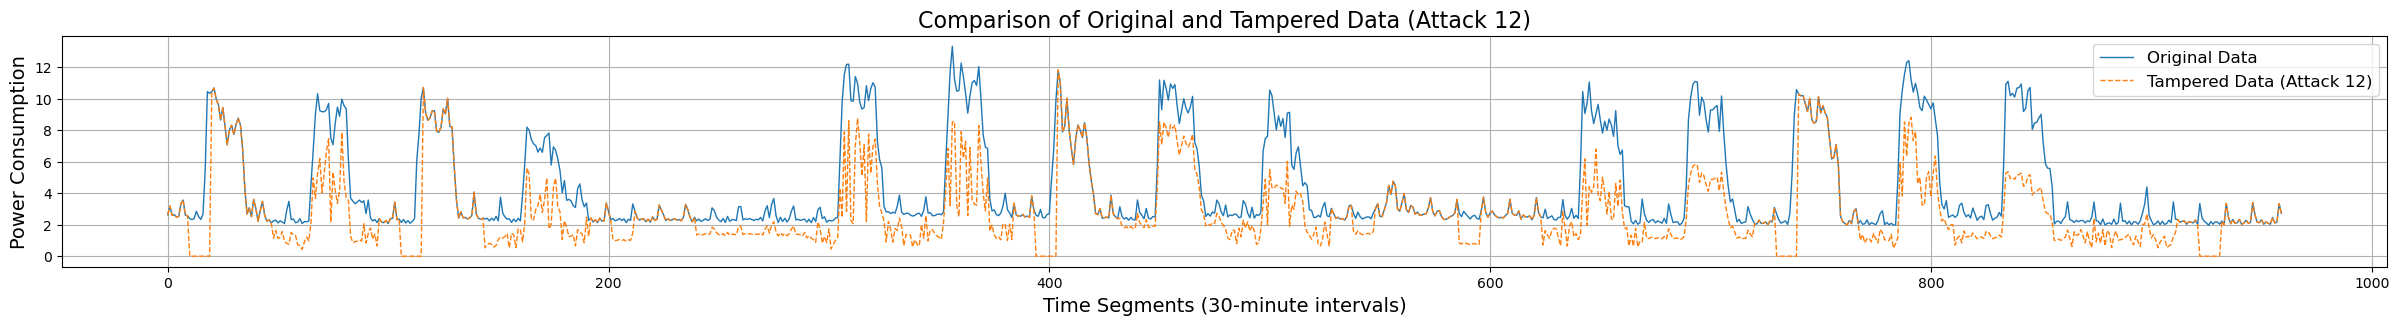

In [172]:

plt.figure(figsize=(30, 3))
plt.plot(user_data.iloc[:960].reset_index(drop=True), label='Original Data', linewidth=1)
plt.plot(tampered_data_attack_12, label='Tampered Data (Attack 12)', linestyle='--', linewidth=1)


plt.title('Comparison of Original and Tampered Data (Attack 12)', fontsize=16)
plt.xlabel('Time Segments (30-minute intervals)', fontsize=14)
plt.ylabel('Power Consumption', fontsize=14)
plt.legend(fontsize=12)
plt.grid()

plt.show()


In [170]:
# Prepare data for tsfresh
combined_data_attack_12 = pd.DataFrame({
    "value": pd.concat([user_data.iloc[:960].reset_index(drop=True), tampered_data_attack_12], ignore_index=True),
    "id": [1] * 960 + [2] * 960,  # Unique IDs for normal and tampered data
    "time": list(range(960)) * 2  # Time indices
})


extraction_settings = ComprehensiveFCParameters()
features_attack_12 = extract_features(
    combined_data_attack_12,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings
)


selected_features_attack_12 = features_attack_12[[
    "value__minimum", "value__maximum", "value__mean", "value__variance", "value__skewness", "value__kurtosis"
]]


selected_features_attack_12.columns = ["Minimum", "Maximum", "Mean", "Variance", "Skewness", "Kurtosis"]
selected_features_attack_12["Label"] = ["Normal", "Tampered"]


selected_features_attack_12.to_csv("feature_table_attack_12.csv", index=False)


print(selected_features_attack_12)


Feature Extraction: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

   Minimum  Maximum      Mean  Variance  Skewness  Kurtosis     Label
1    1.963   13.321  4.342274  8.762922  1.207081 -0.108087    Normal
2    0.000   11.813  2.787470  5.308984  1.515475  1.780778  Tampered



C:\Users\shubh\AppData\Local\Temp\ipykernel_14536\3582982779.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_attack_12["Label"] = ["Normal", "Tampered"]
